In [1]:
import tensorflow as tf

# Sprawdzenie dostępności GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Dostępne urządzenia GPU:", physical_devices)

# Sprawdzenie wersji TensorFlow
print("Wersja TensorFlow:", tf.__version__)

# Jeśli GPU nie jest dostępne, wypisujemy szczegóły
if not physical_devices:
    print("Brak dostępnych urządzeń GPU. Sprawdź, czy masz poprawnie zainstalowane CUDA i cuDNN.")
else:
    # Jeśli GPU jest dostępne, próbujemy ustawić pamięć dynamiczną
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Pamięć dla GPU ustawiona na dynamiczną.")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Source - https://stackoverflow.com/a
# Posted by adelriosantiago, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-26, License - CC BY-SA 4.0

from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']



Dostępne urządzenia GPU: []
Wersja TensorFlow: 2.12.0
Brak dostępnych urządzeń GPU. Sprawdź, czy masz poprawnie zainstalowane CUDA i cuDNN.
Num GPUs Available:  0
['/device:CPU:0']


In [21]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns


In [22]:
# Ścieżka do głównego folderu z danymi
base_dir = r"C:\Users\matik\Documents\Data Sets\Faulty_solar_panel"

# Przygotowanie generatorów danych (treningowych i walidacyjnych)
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir, 
    target_size=(224, 224),  # Rozmiar wejściowy dla ResNet50
    batch_size=32,
    class_mode='categorical',  # Klasyfikacja wieloklasowa
    subset='training'  # Używamy 80% danych do treningu
)

valid_gen = datagen.flow_from_directory(
    base_dir, 
    target_size=(224, 224),  # Rozmiar wejściowy dla ResNet50
    batch_size=32,
    class_mode='categorical',  # Klasyfikacja wieloklasowa
    subset='validation'  # Używamy 20% danych do walidacji
)


Found 711 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


In [23]:
# Ładowanie wstępnie wytrenowanego modelu ResNet50 bez głowy (bo dodamy swoje warstwy)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Zamrażanie warstw bazowych (żeby nie trenować ich ponownie)
base_model.trainable = False

# # Budowanie modelu

# v1
model = models.Sequential([
    base_model,  # Wstępnie wytrenowany model ResNet50
    layers.GlobalAveragePooling2D(),  # Agregacja cech w wektorze
    layers.Dense(512, activation='relu'),  # Warstwa gęsta
    layers.Dense(train_gen.num_classes, activation='softmax')  # Wyjście z klasyfikacją
])

# v2
# model = models.Sequential([
#     base_model,  # Wstępnie wytrenowany model ResNet50
#     layers.GlobalAveragePooling2D(),  # Agregacja cech w wektorze
#     layers.Dense(512, activation='relu'),  # Warstwa gęsta
#     #layers.Dropout(0.2),  # Regularizacja: losowe wyłączanie neuronów
#     layers.Dense(256, activation='relu'),  # Druga warstwa gęsta
#     #layers.Dropout(0.2),  # Kolejny Dropout
#     layers.Dense(train_gen.num_classes, activation='softmax')  # Wyjście z klasyfikacją
# ])

# v3  do bani model
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.4),
#     layers.Dense(train_gen.num_classes, activation='softmax')
# ])



# Kompilacja modelu
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Podsumowanie modelu
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 24,639,878
Trainable params: 1,052,166
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
# Trenowanie modelu
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=100,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // valid_gen.batch_size,
    #callbacks=[early_stopping]
)


Epoch 1/100
22/22 [==============================] - 39s 2s/step - loss: 1.9282 - accuracy: 0.2459 - val_loss: 1.6205 - val_accuracy: 0.3562
Epoch 2/100
22/22 [==============================] - 36s 2s/step - loss: 1.6465 - accuracy: 0.3314 - val_loss: 1.5335 - val_accuracy: 0.3938
Epoch 3/100
22/22 [==============================] - 36s 2s/step - loss: 1.5835 - accuracy: 0.3505 - val_loss: 1.5738 - val_accuracy: 0.2812
Epoch 4/100
22/22 [==============================] - 37s 2s/step - loss: 1.5321 - accuracy: 0.3814 - val_loss: 1.4830 - val_accuracy: 0.4625
Epoch 5/100
22/22 [==============================] - 36s 2s/step - loss: 1.5235 - accuracy: 0.4227 - val_loss: 1.5169 - val_accuracy: 0.3562
Epoch 6/100
22/22 [==============================] - 36s 2s/step - loss: 1.4571 - accuracy: 0.4153 - val_loss: 1.4294 - val_accuracy: 0.4563
Epoch 7/100
22/22 [==============================] - 36s 2s/step - loss: 1.4419 - accuracy: 0.4286 - val_loss: 1.4413 - val_accuracy: 0.4313
Epoch 8/100
2

In [25]:
# Ocena modelu
loss, accuracy = model.evaluate(valid_gen)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


6/6 [==============================] - 9s 1s/step - loss: 1.1934 - accuracy: 0.5000
Loss: 1.193424940109253
Accuracy: 0.5


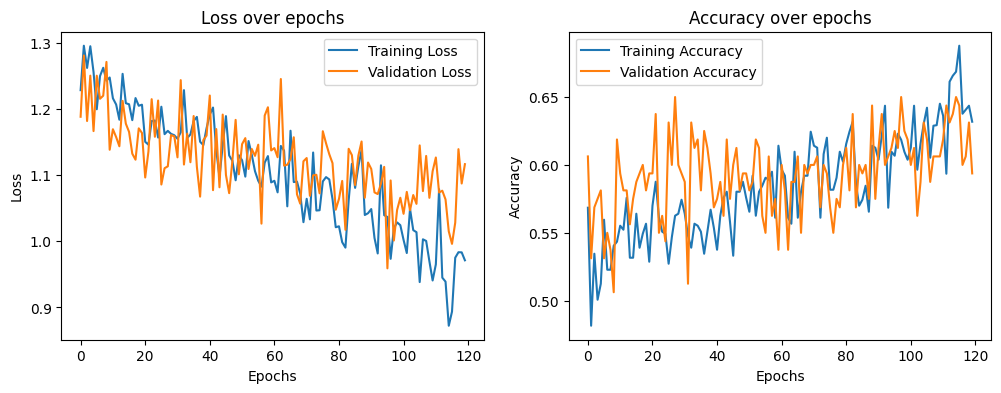

In [16]:
# Rysowanie wykresów dla straty
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Rysowanie wykresów dla dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


6/6 [==============================] - 8s 1s/step
Classification Report:
                   precision    recall  f1-score   support

        Bird-drop       0.27      0.20      0.23        41
            Clean       0.21      0.29      0.24        38
            Dusty       0.00      0.00      0.00        38
Electrical-damage       0.00      0.00      0.00        20
  Physical-Damage       0.00      0.00      0.00        13
     Snow-Covered       0.12      0.46      0.19        24

         accuracy                           0.17       174
        macro avg       0.10      0.16      0.11       174
     weighted avg       0.13      0.17      0.13       174



c:\Users\matik\AppData\Local\Programs\Python\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\matik\AppData\Local\Programs\Python\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\matik\AppData\Local\Programs\Python\envs\tfenv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

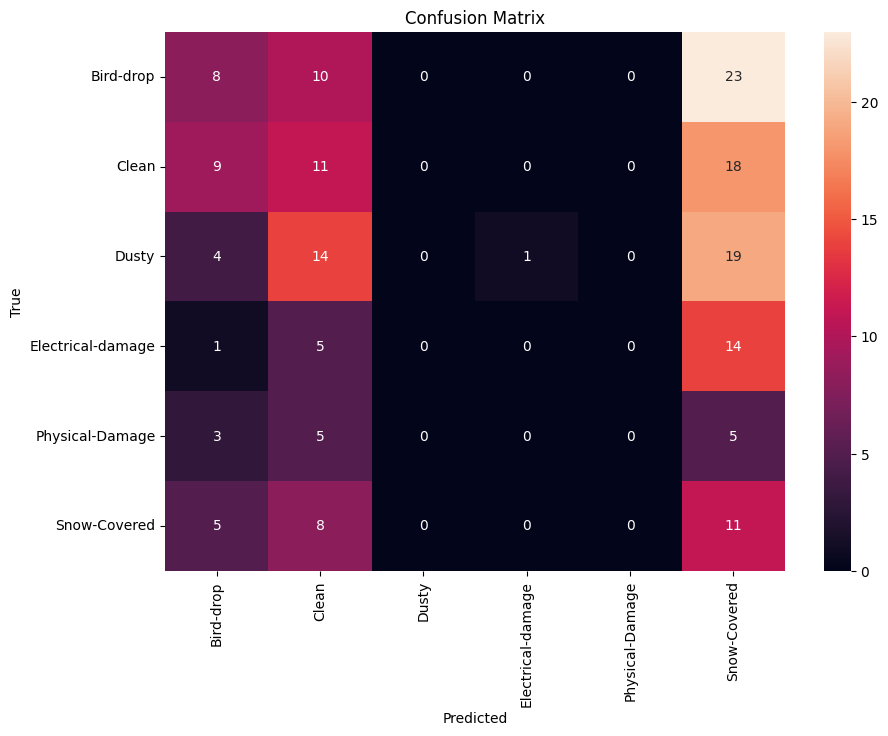

In [10]:
# Pobieranie prawdziwych etykiet
true_labels = valid_gen.classes

# Pobieranie przewidywań modelu
pred_probs = model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)

# Obliczanie confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Wypisanie raportu
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=list(train_gen.class_indices.keys())))

# Rysowanie confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_gen.class_indices.keys(),
            yticklabels=train_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [8]:
model.save('v2_65.h5')